In [2]:
#import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import cv2
import time as time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline
import tensorflow as tf
# import prettytensor as pt
from PIL import Image
import time
from datetime import timedelta
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import keras

In [3]:
# One Hot encoding
def OHE_labels(Y_tr,N_classes):
    OHC = OneHotEncoder()

    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

In [4]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'Downloads/traffic-signs-pickled-dataset/train.p'
testing_file = 'Downloads/traffic-signs-pickled-dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
labels_train = OHE_labels(y_train,43)
labels_test = OHE_labels(y_test,43)

In [5]:
def check_OHE(cls,y):
    check = np.linalg.norm(np.argmax(cls,axis=1)-y)
    if check == 0:
        print('One hot encoding correct, ok to proceed')
    else:
        print('One hot encoding doesnt match the output, check code!!!')

In [6]:
check_OHE(labels_test,y_test)
check_OHE(labels_train,y_train)

One hot encoding correct, ok to proceed
One hot encoding correct, ok to proceed


In [7]:
### basic data summary.

# number of training examples
n_train = len(y_train)

# number of testing examples
n_test = len(y_test)

# what's the shape of an image?
image_shape = np.shape(X_train[1])
# how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print(X_train.shape)
print(y_train.shape)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
(39209, 32, 32, 3)
(39209,)


In [8]:
# image processing

def plot_random_3C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot])
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()
    
def plot_random_1C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot],cmap='gray')
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()   

    
def plot_random_preprocess(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(pre_process_image(X[ind_plot]),cmap='gray')
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()


def pre_process_image(image):

    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    #image = image[:,:,0]
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    image = image/255.-.5
    #image = cv2.resize(image, (img_resize,img_resize),interpolation = cv2.INTER_CUBIC)

    return image

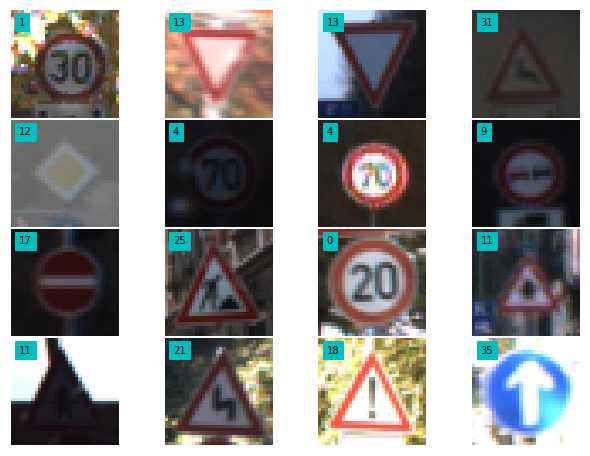

In [12]:
plot_random_3C(4,4,X_train,y_train) # testing

In [9]:
# image resizing

img_resize = 32
N_classes = 43
image_shape = (img_resize,img_resize)
img_size_flat = img_resize*img_resize


image_GS_train = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))],
                          dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))],
                          dtype = np.float32)

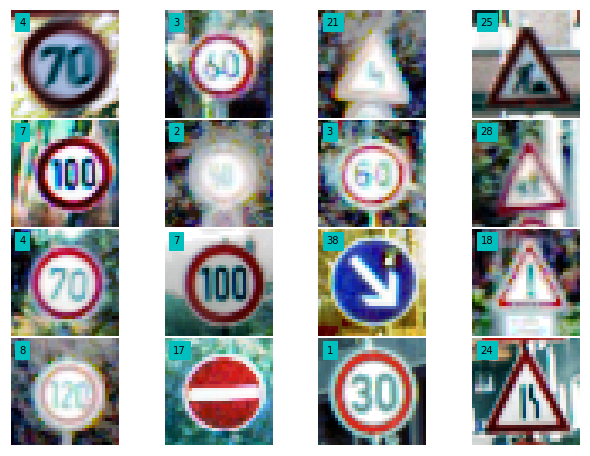

In [22]:
plot_random_3C(4,4,image_GS_train+.5,y_train)

In [23]:
data_i = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
data_i_sorted = sorted(data_i, key=lambda x: x[1])

In [24]:
data_pd = pd.read_csv('Downloads/signnames.csv')

In [25]:
data_pd['Occurance'] = pd.Series(np.asarray(data_i_sorted).T[1], index=np.asarray(data_i_sorted).T[0])
data_pd_sorted = data_pd.sort_values(['Occurance'],ascending=[0]).reset_index()
data_pd_sorted = data_pd_sorted.drop('index', 1)

In [26]:
data_pd_sorted.head(10)

,ClassId,SignName,Occurance
0,2,Speed limit (50km/h),2010
1,1,Speed limit (30km/h),1980
2,13,Yield,1920
3,12,Priority road,1890
4,38,Keep right,1860
5,10,No passing for vehicles over 3.5 metric tons,1800
6,4,Speed limit (70km/h),1770
7,5,Speed limit (80km/h),1650
8,25,Road work,1350
9,9,No passing,1320


In [27]:
data_pd_sorted.tail(10)

,ClassId,SignName,Occurance
33,21,Double curve,270
34,29,Bicycles crossing,240
35,24,Road narrows on the right,240
36,41,End of no passing,210
37,42,End of no passing by vehicles over 3.5 metric ...,210
38,32,End of all speed and passing limits,210
39,27,Pedestrians,210
40,37,Go straight or left,180
41,19,Dangerous curve to the left,180
42,0,Speed limit (20km/h),180


<BarContainer object of 43 artists>

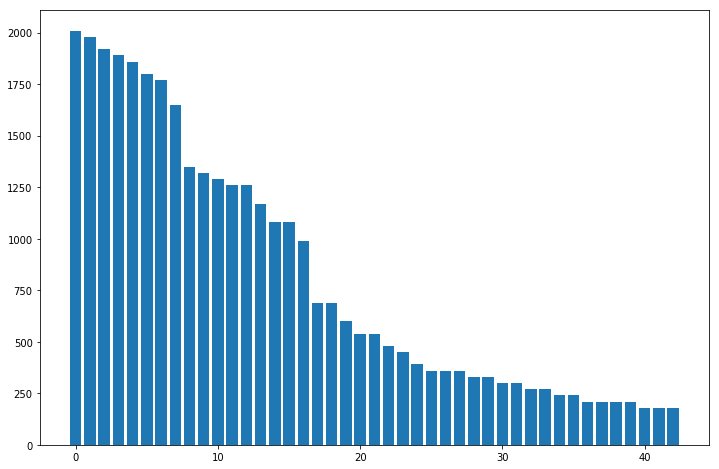

In [28]:
plt.figure(figsize=(12,8))
plt.bar(range(43),height=data_pd_sorted["Occurance"])

In [10]:
img_resize = 32
def transform_image(image,ang_range,shear_range,trans_range):

    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))

    image = pre_process_image(image)

    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    #image = image[:,:,0]
    #image = cv2.resize(image, (img_resize,img_resize),interpolation = cv2.INTER_CUBIC)

    return image

def get_index_dict(y_train):
    # Returns indices of each label
    # Assumes that the labels are 0 to N-1
    dict_indices = {}
    ind_all = np.arange(len(y_train))

    for i in range(len(np.unique(y_train))):
        ind_i = ind_all[y_train == i]
        dict_indices[i] = ind_i
        #print(ind_i)
    return dict_indices

def gen_transformed_data(X_train,y_train,N_classes,n_each,ang_range,shear_range,trans_range,randomize_Var):

   dict_indices = get_index_dict(y_train)
   n_class = len(np.unique(y_train))
   X_arr = []
   Y_arr = []
   for i in range(n_class):
       len_i = len(dict_indices[i])
       ind_rand = np.random.randint(0,len_i,n_each)
       ind_dict_class  = dict_indices[i]

       for i_n in range(n_each):
           img_trf = transform_image(X_train[ind_dict_class[ind_rand[i_n]]],
                                     ang_range,shear_range,trans_range)
           X_arr.append(img_trf)
           Y_arr.append(i)

   X_arr = np.array(X_arr,dtype = np.float32())
   Y_arr = np.array(Y_arr,dtype = np.float32())

   if (randomize_Var == 1):
       len_arr = np.arange(len(Y_arr))
       np.random.shuffle(len_arr)
       X_arr[len_arr] = X_arr
       Y_arr[len_arr] = Y_arr

   labels_arr = OHE_labels(Y_arr,43)

   return X_arr,Y_arr,labels_arr


def gen_extra_data(X_train,y_train,N_classes,n_each,ang_range,shear_range,trans_range,randomize_Var):

    dict_indices = get_index_dict(y_train)
    n_class = len(np.unique(y_train))
    X_arr = []
    Y_arr = []
    n_train = len(X_train)
    for i in range(n_train):
        #X_arr.append(transform_image(X_train[i],0,0,0)/255.)
        #Y_arr.append(y_train[i])
        for i_n in range(n_each):
            img_trf = transform_image(X_train[i],
                                      ang_range,shear_range,trans_range)
            X_arr.append(img_trf)
            Y_arr.append(y_train[i])

    X_arr = np.array(X_arr,dtype = np.float32())
    Y_arr = np.array(Y_arr,dtype = np.float32())

    if (randomize_Var == 1):
        len_arr = np.arange(len(Y_arr))
        np.random.shuffle(len_arr)
        X_arr[len_arr] = X_arr
        Y_arr[len_arr] = Y_arr

    labels_arr = OHE_labels(Y_arr,43)

    return X_arr,Y_arr,labels_arr

In [11]:
Image_train_GS_rot,y_train_rot,labels_train_rot = gen_transformed_data(X_train,y_train,
                                                                       43,100,30,5,5,1)

In [12]:
len(Image_train_GS_rot) # this is the extra data generated: 43 classes x 50 images each

4300

In [13]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(Image_train_GS_rot_1)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = Image_train_GS_rot_1[idx, :,:,:]
    labels_batch = labels_train_rot[idx, :]

    return features_batch, labels_batch

In [14]:
# Stack the augmented data on the original data

print('Original X data: ',X_train.shape)
print('Augmented data: ', Image_train_GS_rot.shape)
X_combined_train = np.vstack((X_train, Image_train_GS_rot))
print('Combined data: ',X_combined_train.shape)

print('\nOriginal y data: ',y_train.shape)
print('Augmented data: ', y_train_rot.shape)
y_combined_train = np.concatenate((y_train, y_train_rot))
print('Combined data: ',y_combined_train.shape)

print('\nOriginal y data: ',labels_train.shape)
print('Augmented data: ', labels_train_rot.shape)
labels_combined_train = np.vstack((labels_train, labels_train_rot))
print('Combined data: ',labels_combined_train.shape)


Original X data:  (39209, 32, 32, 3)
Augmented data:  (4300, 32, 32, 3)
Combined data:  (43509, 32, 32, 3)

Original y data:  (39209,)
Augmented data:  (4300,)
Combined data:  (43509,)

Original y data:  (39209, 43)
Augmented data:  (4300, 43)
Combined data:  (43509, 43)


In [16]:
X_train_reshape = np.reshape(X_combined_train, (43509,3,32,32))/255
print('Reshaped train data: ',X_train_reshape.shape)

X_test_reshape = np.reshape(X_test, (12630,3,32,32))/255
print('Reshaped test data: ',X_test_reshape.shape)


Reshaped train data:  (43509, 3, 32, 32)
Reshaped test data:  (12630, 3, 32, 32)


In [17]:
# a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers.

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model

model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(32, 32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(43,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(), metrics=['accuracy']
              )

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
__________

In [ ]:

model.fit(X_combined_train,labels_combined_train,batch_size=32,epochs=10,verbose=1)
accuracy = model.evaluate(x=X_test,y=labels_test,batch_size=32)
print("Accuracy: ",accuracy[1])

# Accuracy was 44%. Stinks.

# Using a pre-trained model (vgg16 - compatible with 32x32x3 inputs)

In [18]:
from keras import optimizers
from keras import applications
from keras.models import Model
#Using TensorFlow backend.

# dimensions of our images.
img_width, img_height = 32, 32

model_vgg = applications.VGG16(include_top=False, weights='imagenet') # instance of vgg16
# Note include_top=False indicates dropping final fully connected layer


In [19]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [72]:
# Create an image generator, function to create images

from keras import optimizers
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rescale=1./255,        # normalize pixel values to [0,1]
        shear_range=0.2,       # randomly applies shearing transformation
        zoom_range=0.2,        # randomly applies shearing transformation
        horizontal_flip=False)  # randomly flip the images

datagen.fit(X_combined_train) # calculates needed statistics on training data

def aug_img(orig_x,orig_y,batch_size):
    X_aug = []
    y_aug = []
    num_augmented = 0
    for X_batch, y_batch in datagen.flow(orig_x, orig_y, batch_size=batch_size, shuffle=True):
        X_aug.append(X_batch)
        y_aug.append(y_batch)
        num_augmented += batch_size
        if num_augmented == 6400: #orig_x.shape[0]
            break
    X_aug = np.concatenate(X_aug)
    y_aug = np.concatenate(y_aug)
    print('Augmented X shape: ',X_aug.shape)
    print('Augmented y shape: ',y_aug.shape)
    return X_aug, y_aug



In [73]:
X_train_aug, y_train_aug = aug_img(X_combined_train,y_combined_train,32) # Create augmented training images

Augmented X shape:  (6400, 32, 32, 3)
Augmented y shape:  (6400,)


In [74]:
X_test_aug, y_test_aug = aug_img(X_test,y_test,32) # Create augmented test images

Augmented X shape:  (6400, 32, 32, 3)
Augmented y shape:  (6400,)


In [75]:
np.unique(y_train_aug, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42.], dtype=float32),
 array([ 76, 329, 383, 243, 341, 301, 100, 246, 259, 248, 277, 227, 327,
        336, 126, 109,  74, 209, 201,  49,  54,  59,  75,  88,  49, 232,
         82,  34,  75,  36,  74, 128,  40, 109,  72, 169,  69,  43, 295,
         37,  42,  39,  38]))

In [76]:
train_samples = len(X_test_aug)
batch_size = 32

bottleneck_features_train = model_vgg.predict(X_train_aug, train_samples // batch_size, verbose=1)
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)


6400/6400 [==============================] - 4433s 693ms/step


In [78]:
validation_samples = len(X_test_aug)
validation_samples = 256

bottleneck_features_validation = model_vgg.predict(X_test_aug, validation_samples // batch_size, verbose=1)
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

6400/6400 [==============================] - 4155s 649ms/step


In [79]:
#Now we can load it...

import keras.utils as ku

train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = ku.to_categorical(y_train_aug, num_classes=43)

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = ku.to_categorical(y_test_aug, num_classes=43)

In [80]:
#And define and train the custom fully connected neural network :

epochs = 10

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(43, activation='sigmoid'))

model_top.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_top.fit(train_data, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_data, validation_labels))

Train on 6400 samples, validate on 6400 samples
Epoch 1/10
6400/6400 [==============================] - 16s 2ms/step - loss: 0.1075 - acc: 0.9721 - val_loss: 0.0736 - val_acc: 0.9787
Epoch 2/10
6400/6400 [==============================] - 11s 2ms/step - loss: 0.0744 - acc: 0.9790 - val_loss: 0.0655 - val_acc: 0.9794
Epoch 3/10
6400/6400 [==============================] - 9s 1ms/step - loss: 0.0669 - acc: 0.9798 - val_loss: 0.0622 - val_acc: 0.9802
Epoch 4/10
6400/6400 [==============================] - 8s 1ms/step - loss: 0.0629 - acc: 0.9804 - val_loss: 0.0602 - val_acc: 0.9807
Epoch 5/10
6400/6400 [==============================] - 8s 1ms/step - loss: 0.0600 - acc: 0.9810 - val_loss: 0.0592 - val_acc: 0.9809
Epoch 6/10
6400/6400 [==============================] - 8s 1ms/step - loss: 0.0581 - acc: 0.9814 - val_loss: 0.0586 - val_acc: 0.9809
Epoch 7/10
6400/6400 [==============================] - 9s 1ms/step - loss: 0.0563 - acc: 0.9817 - val_loss: 0.0577 - val_acc: 0.9814
Epoch 8/10
6

In [81]:
model_top.evaluate(validation_data, validation_labels)

6400/6400 [==============================] - 2s 383us/step


[0.05693452993407846, 0.9815806594491004]

In [82]:
y_proba = model_top.predict(train_data,verbose=1)
#y_classes = keras.np_utils.probas_to_classes(y_proba)

6400/6400 [==============================] - 2s 375us/step


In [83]:
y_proba[1]

array([4.9803811e-03, 2.0940408e-02, 6.1826985e-02, 8.5117050e-02,
       9.5641993e-02, 6.0504694e-02, 1.1276921e-04, 9.4484366e-02,
       1.6600539e-01, 1.4838026e-02, 4.8502780e-02, 1.2017486e-04,
       2.2746134e-04, 3.3249624e-05, 8.4453850e-04, 8.6582210e-03,
       2.4813311e-02, 2.2366105e-04, 2.1905807e-05, 3.2663099e-06,
       6.1581422e-06, 1.7567341e-05, 1.4950211e-05, 5.9134413e-06,
       1.2720377e-06, 4.3903270e-05, 2.2035858e-05, 3.6210192e-06,
       5.1508191e-06, 8.1878397e-07, 1.9744255e-05, 2.3359687e-05,
       5.5815628e-05, 1.3034379e-04, 3.6278940e-04, 1.4237509e-04,
       9.6880649e-06, 4.7120452e-06, 8.0696668e-04, 1.5080188e-05,
       4.6302457e-06, 1.1128408e-05, 2.3808527e-05], dtype=float32)

In [141]:
y_test_prob = model_top.predict(validation_data,verbose=1)

6400/6400 [==============================] - 13s 2ms/step


In [144]:
best_test_prob = np.argsort(y_test_prob)[:,-1]
label_and_predicted = np.transpose(np.stack((best_test_prob, y_test_aug)))
diff = test[:,0] - test[:,1]

In [145]:
def unique_count(a):
    unique, inverse = np.unique(a, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    return np.vstack(( unique, count)).T

print(unique_count(diff))

[[ -40    1]
 [ -39    4]
 [ -37    2]
 [ -36   19]
 [ -35    8]
 [ -34    5]
 [ -33   11]
 [ -32    6]
 [ -31    6]
 [ -30    3]
 [ -29    3]
 [ -28    5]
 [ -27   13]
 [ -26   34]
 [ -25    9]
 [ -23    2]
 [ -22    3]
 [ -21   11]
 [ -20    8]
 [ -19   21]
 [ -18   12]
 [ -17   15]
 [ -16   13]
 [ -15   18]
 [ -14   47]
 [ -13   39]
 [ -12   37]
 [ -11   36]
 [ -10   42]
 [  -9   16]
 [  -8   47]
 [  -7   89]
 [  -6  100]
 [  -5   91]
 [  -4  103]
 [  -3  210]
 [  -2  184]
 [  -1  294]
 [   0 3137]
 [   1  309]
 [   2  338]
 [   3  267]
 [   4  124]
 [   5  142]
 [   6   88]
 [   7  128]
 [   8   34]
 [   9   34]
 [  10   23]
 [  11   23]
 [  12   33]
 [  13   23]
 [  14   56]
 [  15    4]
 [  16    2]
 [  17    2]
 [  18    2]
 [  19    4]
 [  20    8]
 [  21    4]
 [  22    5]
 [  23    5]
 [  24    3]
 [  25    1]
 [  26    8]
 [  28    4]
 [  29    3]
 [  30    2]
 [  31    1]
 [  33    1]
 [  34    4]
 [  35    4]
 [  36    5]
 [  37    1]
 [  38    1]]
